In [1]:
import os
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.nn import sigmoid, relu
from jax.tree_util import tree_map

import optax
import functools

import torch
from torch.utils import data

In [2]:
import matplotlib.pyplot as plt

In [3]:
import util as U

# Load data

In [4]:
iwave = 1

In [5]:
_thetas = []
for i in range(10): 
    _thetas.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.thetas_sps.npz' % i))['arr_0'])
_thetas = np.concatenate(_thetas, axis=0)    

In [6]:
avg_thetas = np.mean(_thetas, axis=0)
std_thetas = np.std(_thetas, axis=0)
thetas = (_thetas - avg_thetas)/std_thetas

In [7]:
_x_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.x_pca.w%i.npy' % iwave))

In [8]:
avg_x_pca = np.mean(_x_pca, axis=0)
std_x_pca = np.std(_x_pca, axis=0)
x_pca = (_x_pca - avg_x_pca)/std_x_pca

In [9]:
def numpy_collate(batch):
    return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))

In [10]:
N_train = int(0.9*x_pca.shape[0])
train_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[:N_train]), torch.tensor(x_pca[:N_train])), batch_size=500)
valid_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[N_train:]), torch.tensor(x_pca[N_train:])), batch_size=500)

# set up MLP in jax

In [11]:
def nonlin_act(x, beta, gamma):
    return (gamma + sigmoid(beta * x) * (1 - gamma)) * x

def init_mlp_params(layer_sizes, scale=1e-2):
    keys = random.split(random.PRNGKey(1), len(layer_sizes))

    params = []
    for i, key in zip(np.arange(len(layer_sizes)-2), keys): 
        m, n = layer_sizes[i], layer_sizes[i+1]
        #w_key, b_key = random.split(key, num=2)
        #params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
        w_key, b_key, _a_key, _b_key = random.split(key, num=4)
        params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,)), 
                      scale * random.normal(_a_key, (n,)), scale * random.normal(_b_key, (n,))])

    m, n = layer_sizes[-2], layer_sizes[-1]        
    w_key, b_key = random.split(keys[-1], num=2)
    params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
    return params

@functools.partial(jax.vmap, in_axes=(None, 0))
def forward(params, inputs):
    activations = inputs
    #for w, b in params[:-1]:
    for w, b, beta, gamma in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = nonlin_act(outputs, beta, gamma) #relu(outputs)#

    final_w, final_b = params[-1]
    return jnp.dot(final_w, activations) + final_b

def mse_loss(params, inputs, targets):
    preds = forward(params, inputs)
    return jnp.mean((preds - targets) ** 2)

# train using `optax`

In [13]:
    # Update function
    @jit
    def update(params, opt_state, inputs, targets):
        loss, grads = jax.value_and_grad(mse_loss)(params, inputs, targets)
        updates, opt_state = gradient_transform.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        #updates, opt_state = optimizer.update(grads, opt_state)
        #params = optax.apply_updates(params, updates)
        return params, opt_state, loss

In [14]:
layer_sizes = [thetas.shape[1], 512, 512, 512, x_pca.shape[1]]
learning_rate = 1e-2
n_epochs = 1000

# Initialize the MLP and optimizer
params = init_mlp_params(layer_sizes)
optimizer = optax.adam(learning_rate)

total_steps = n_epochs*len(train_dataloader)
scheduler = optax.exponential_decay(init_value=learning_rate, 
                                    transition_steps=total_steps, 
                                    transition_begin=int(total_steps*0.25),
                                    decay_rate=0.01)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

# Initialize optimizer state
#opt_state = optimizer.init(params)
opt_state = gradient_transform.init(params)


# Training loop
train_loss, valid_loss, best_valid_loss, best_epoch = [], [], np.inf, 0
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x, y in train_dataloader:        
        params, opt_state, loss = update(params, opt_state, x, y)        
        epoch_loss += loss
    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)
    
    _loss = 0.
    for x, y in valid_dataloader: 
        loss = mse_loss(params, x, y)
        _loss += loss
    valid_loss.append(_loss/len(valid_dataloader))

        # early stopping after 20 epochs
        if valid_loss[-1] < best_valid_loss: 
            best_valid_loss = valid_loss[-1]
            best_epoch = epoch
            best_params = params.copy()

        if epoch > best_epoch + 20: 
            break

        if epoch % 10 == 0: print(f"Epoch {epoch}, Loss: {epoch_loss}, Valid Loss: {valid_loss[-1]}")

2024-04-23 10:10:48.616694: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:822] Compiling 60 configs for 2 fusions on a single thread.


Epoch 0, Loss: 0.4775407910346985, Valid Loss: 0.36851590871810913
Epoch 10, Loss: 0.2690272629261017, Valid Loss: 0.30130961537361145
Epoch 20, Loss: 0.25133568048477173, Valid Loss: 0.26637545228004456
Epoch 30, Loss: 0.24309304356575012, Valid Loss: 0.24336637556552887
Epoch 40, Loss: 0.23641324043273926, Valid Loss: 0.2404726892709732
Epoch 50, Loss: 0.23181086778640747, Valid Loss: 0.23567785322666168
Epoch 60, Loss: 0.22938622534275055, Valid Loss: 0.23251056671142578
Epoch 70, Loss: 0.22644199430942535, Valid Loss: 0.23267053067684174
Epoch 80, Loss: 0.22441250085830688, Valid Loss: 0.2264631986618042


In [18]:
forward(best_params, np.array([thetas[0]]))

Array([[ 0.45257834, -1.1525862 , -0.60280585,  0.8674047 , -0.5150228 ,
        -0.5431272 ,  0.5410697 , -0.23094985, -0.40389535,  0.5369801 ,
        -0.21749254,  0.4778834 , -0.5951853 , -0.87025243, -0.80401963,
        -0.2550844 , -0.6326293 ,  1.1550324 ,  0.22345017,  0.2016717 ,
        -0.37265924,  0.17371622, -1.380105  ,  0.65502125,  0.39262664,
        -0.0773644 , -0.01441205, -0.46606576,  0.11494537,  0.3779379 ,
        -0.20357756,  0.6585794 , -1.2069836 , -1.0266585 ,  0.12660512,
         0.25506368,  0.28361756,  0.13810842,  0.6867943 , -0.2790025 ,
        -0.97465855,  0.64015585,  0.67995   , -0.78516835, -0.47887063,
        -0.94540757,  0.58818495,  0.3671996 , -0.05400606,  0.11857963]],      dtype=float32)

In [19]:
x_pca[0]

array([ 0.30943524, -1.13289034, -0.6653249 ,  0.81677219, -0.64704121,
       -0.69456442,  0.28655735, -0.27562407, -0.44432556,  0.62977647,
       -0.20037988,  0.57277916, -0.67910717, -0.66117903, -0.82910167,
       -0.3129925 , -0.61549791,  1.05481832,  0.2210822 ,  0.22595005,
       -0.14898076,  0.05213284, -1.38782921,  0.60607091,  0.41044452,
       -0.12768584, -0.13348063, -0.57776957,  0.1525249 ,  0.47004961,
       -0.05956924,  0.85542953, -1.33422384, -0.72609636,  0.29622136,
        0.14193092,  0.33000221,  0.14298564,  0.865948  , -0.39399038,
       -0.72042464,  0.39615588,  0.80161837, -0.79733654, -0.12604371,
       -1.12663324,  0.70457986,  0.54110416, -0.06183649,  0.53769653])

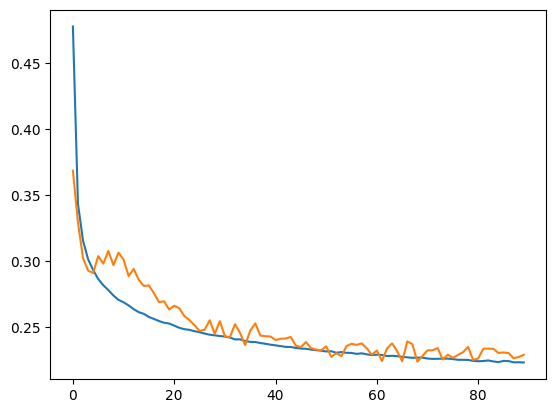

In [20]:
plt.plot(train_loss)
plt.plot(valid_loss)

# validate trained NN

In [18]:
M_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.M_pca.w0.npy'))
avg_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.avg_logseds.w0.npy'))
std_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.std_logseds.w0.npy'))

In [ ]:
wave_bins = [(1.5e3, 3.525e3), 
             (3.525e3, 5.5e3), (5.5e3, 7.5e3), # these wavelength ranges are determined by the MILES spectral library wavelength (3525 - 7500)
             (7.5e3, 4e5)]
wave_bin = wave_bins[iwave]

_w = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.0.waves.npz'))['arr_0'][0]
wlim = np.ones(len(_w)).astype(bool)
if wave_bin[0] is not None: wlim &= (_w > wave_bin[0])
if wave_bin[1] is not None: wlim &= (_w < wave_bin[1])   
    
logseds = [] 
for seed in range(10):
    logseds.append(np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.seds.npz' % seed))['arr_0'][:,wlim]))
logseds = np.concatenate(logseds)

In [ ]:
y_pred = []
for x, y in valid_dataloader: 
    y_pred.append(forward(best_params, x))
y_pred = np.concatenate(y_pred, axis=0)

y_pred *= std_x_pca
y_pred += avg_x_pca

logsed_pred = np.dot(y_pred, M_pca) * std_logsed + avg_logsed